In [1]:
from scipy import integrate

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
Path('../fig').mkdir(parents=True, exist_ok=True)

In [2]:
def plot_parameters():
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["figure.figsize"] = [20, 9]  # plot image size
    SMALL_SIZE = 20
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 32

    plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
    plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc("xtick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("ytick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc("figure", titlesize=BIGGER_SIZE)

    return SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE


In [3]:
def luminosity_distance(redshift):
    """
    Compute luminosity distance as function of the redshift

    Parameters
    ----------
        redshift: scalar
            Cosmological redshift value

    Returns
    -------
        scalar: Returns luminosity distance relative to given redshift
    """

    # cosmological constants
    # values from https://arxiv.org/pdf/1807.06209.pdf
    h = 0.6796
    H_0 = h * 100 * 1e+3  # Huble constant m s**-1 Mpc**-1
    clight = 2.99792458e8  # speed of lightm s**-1
    Dist_H = clight / H_0  # Huble distance

    Omega_M = 0.315
    Omega_Λ = 1 - Omega_M
    Omega_K = 0.0

    def Ez(z): return 1 / np.sqrt(Omega_M * (1 + z)
                                  ** 3 + Omega_K * (1 + z)**2 + Omega_Λ)
    Dist_C = Dist_H * integrate.quad(Ez, 0, redshift)[0]
    Dist_L = (1 + redshift) * Dist_C

    return Dist_L

In [4]:
def plot_settings(ax, frame, mass_ratio):
    ax.text(15, 4, r"$q = $"+f'{mass_ratio}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 10)
    ax.set_xlim(10, 1e9)
    ax.set_ylabel(r'redshift, $z$')
    ax.set_xlabel(r'final mass $[M_\odot]$'+f'({frame} frame)')

    axx = ax.twinx()
    mn, mx = ax.get_ylim()
    axx.set_yscale("log")
    axx.set_ylim(luminosity_distance(mn) * 1e-3,
                 luminosity_distance(mx) * 1e-3)
    axx.set_ylabel("Luminosity distance [Gpc]")

    
    ## set y ticks    
    x_major = mpl.ticker.LogLocator(base = 10.0, numticks = 20)
    x_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 20)
    
    ax.xaxis.set_major_locator(x_major)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 10)
    y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)

    ax.yaxis.set_major_locator(y_major)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    axx.yaxis.set_major_locator(y_major)
    axx.yaxis.set_minor_locator(y_minor)
    axx.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    

In [5]:
def catalog_plot(ax, q, frame:str):
    catalog = pd.read_csv(
        "../data/catalog_bbh.csv").sort_values(by="final_mass_source")

    q_condition_up = (
        (catalog["mass_1_source"] + catalog["mass_1_source_upper"]
         ) / (catalog["mass_2_source"] + catalog["mass_2_source_lower"]
              ) > q)
    q_condition_low = (q > (
        catalog["mass_1_source"] + catalog["mass_1_source_lower"]
    ) / (catalog["mass_2_source"] + catalog["mass_2_source_upper"])
    )
    q_condition = q_condition_up & q_condition_low
    chi_eff_condition_up = (
        (catalog["chi_eff"] + catalog["chi_eff_upper"]
         ) > 0)
    chi_eff_condition_low = (0 > (
        catalog["chi_eff"] + catalog["chi_eff_lower"]
    ))
    chi_eff_condition = chi_eff_condition_up & chi_eff_condition_low
    compatible = catalog[q_condition & chi_eff_condition]

    extra = catalog[~(q_condition & chi_eff_condition)]
    if frame == 'detector':
        X_compatible = compatible["final_mass_source"] * (1 + compatible["redshift"])
        X_extra = extra["final_mass_source"] * (1 + extra["redshift"])
    else:
        X_compatible = compatible["final_mass_source"]
        X_extra = extra["final_mass_source"]
    ax.scatter(
        X_compatible,
        compatible["redshift"],
        color='gold',
        edgecolors="darkgoldenrod",
        lw=2,
        alpha=1,
        # label = "catalog",
        marker="o",
        s=50,
    )
    ax.scatter(
        X_extra,
        extra["redshift"],
        color='silver',
        edgecolors="dimgray",
        lw=2,
        alpha=1,
        # label = "catalog",
        marker="o",
        s=50,
        zorder=-10
    )

In [6]:
def plot_2_modes(data_frame):    
    plot_parameters()
    
    fig, axs = plt.subplots(2, 2, dpi = 400)
    
    plt.ylim(1e-2, 1e1)
    plt.xlim(1e1, 1e9)
    
    mass_ratios = [1.5, 10]
    frames = ['source', 'detector']
    detectors = ['LIGO', 'ET', 'CE', 'LISA']
    modes = ['(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']
    two_modes = [('(2,2,0)',mode) for mode in modes]

    colors = {
        '(2,2,1) II': 'tab:red',
        '(3,3,0)': 'tab:green',
        '(4,4,0)': 'tab:blue',
        '(2,1,0)': 'tab:orange',
    }
    linestyles = {
        'LIGO': '-',
        'ET': '--',
        'CE': ':',
        'LISA': '-',
    }
    i = 0 
    for mass_ratio in mass_ratios:
        j = 0 
        for frame in frames:
            catalog_plot(axs[i,j], mass_ratio, frame)
            plot_settings(axs[i,j], frame, mass_ratio)
                    
            for detector in detectors:
                for comb in two_modes:
                    condition = (data_frame.modes == f'{comb}')&(data_frame.detector == detector)&(data_frame.mass_ratio == mass_ratio)
                    df_plot = data_frame[condition]
                    if frame == 'detector':
                        masses_detector = df_plot.apply(lambda row: row.masses*(1+row.redshifts), axis=1)
                        df_plot = df_plot.assign(masses=masses_detector)
                    if detector == 'LISA':
                        axs[i,j].plot(df_plot.masses, df_plot.redshifts, color = colors[comb[1]], ls = linestyles[detector], lw = 3, label='(2,2,0) + '+comb[1][:7])
                    else:
                        axs[i,j].plot(df_plot.masses, df_plot.redshifts, color = colors[comb[1]], ls = linestyles[detector], lw = 3)


            j += 1
        i += 1
        

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=10)
    fig.tight_layout(rect=(0,0,1,0.9))

    plt.savefig('../fig/rayleigh_2modes.pdf', format='pdf', bbox_inches='tight', dpi = 400)

In [7]:
data_frame = pd.read_csv('../data/two_modes_horizons.dat', sep='\t')


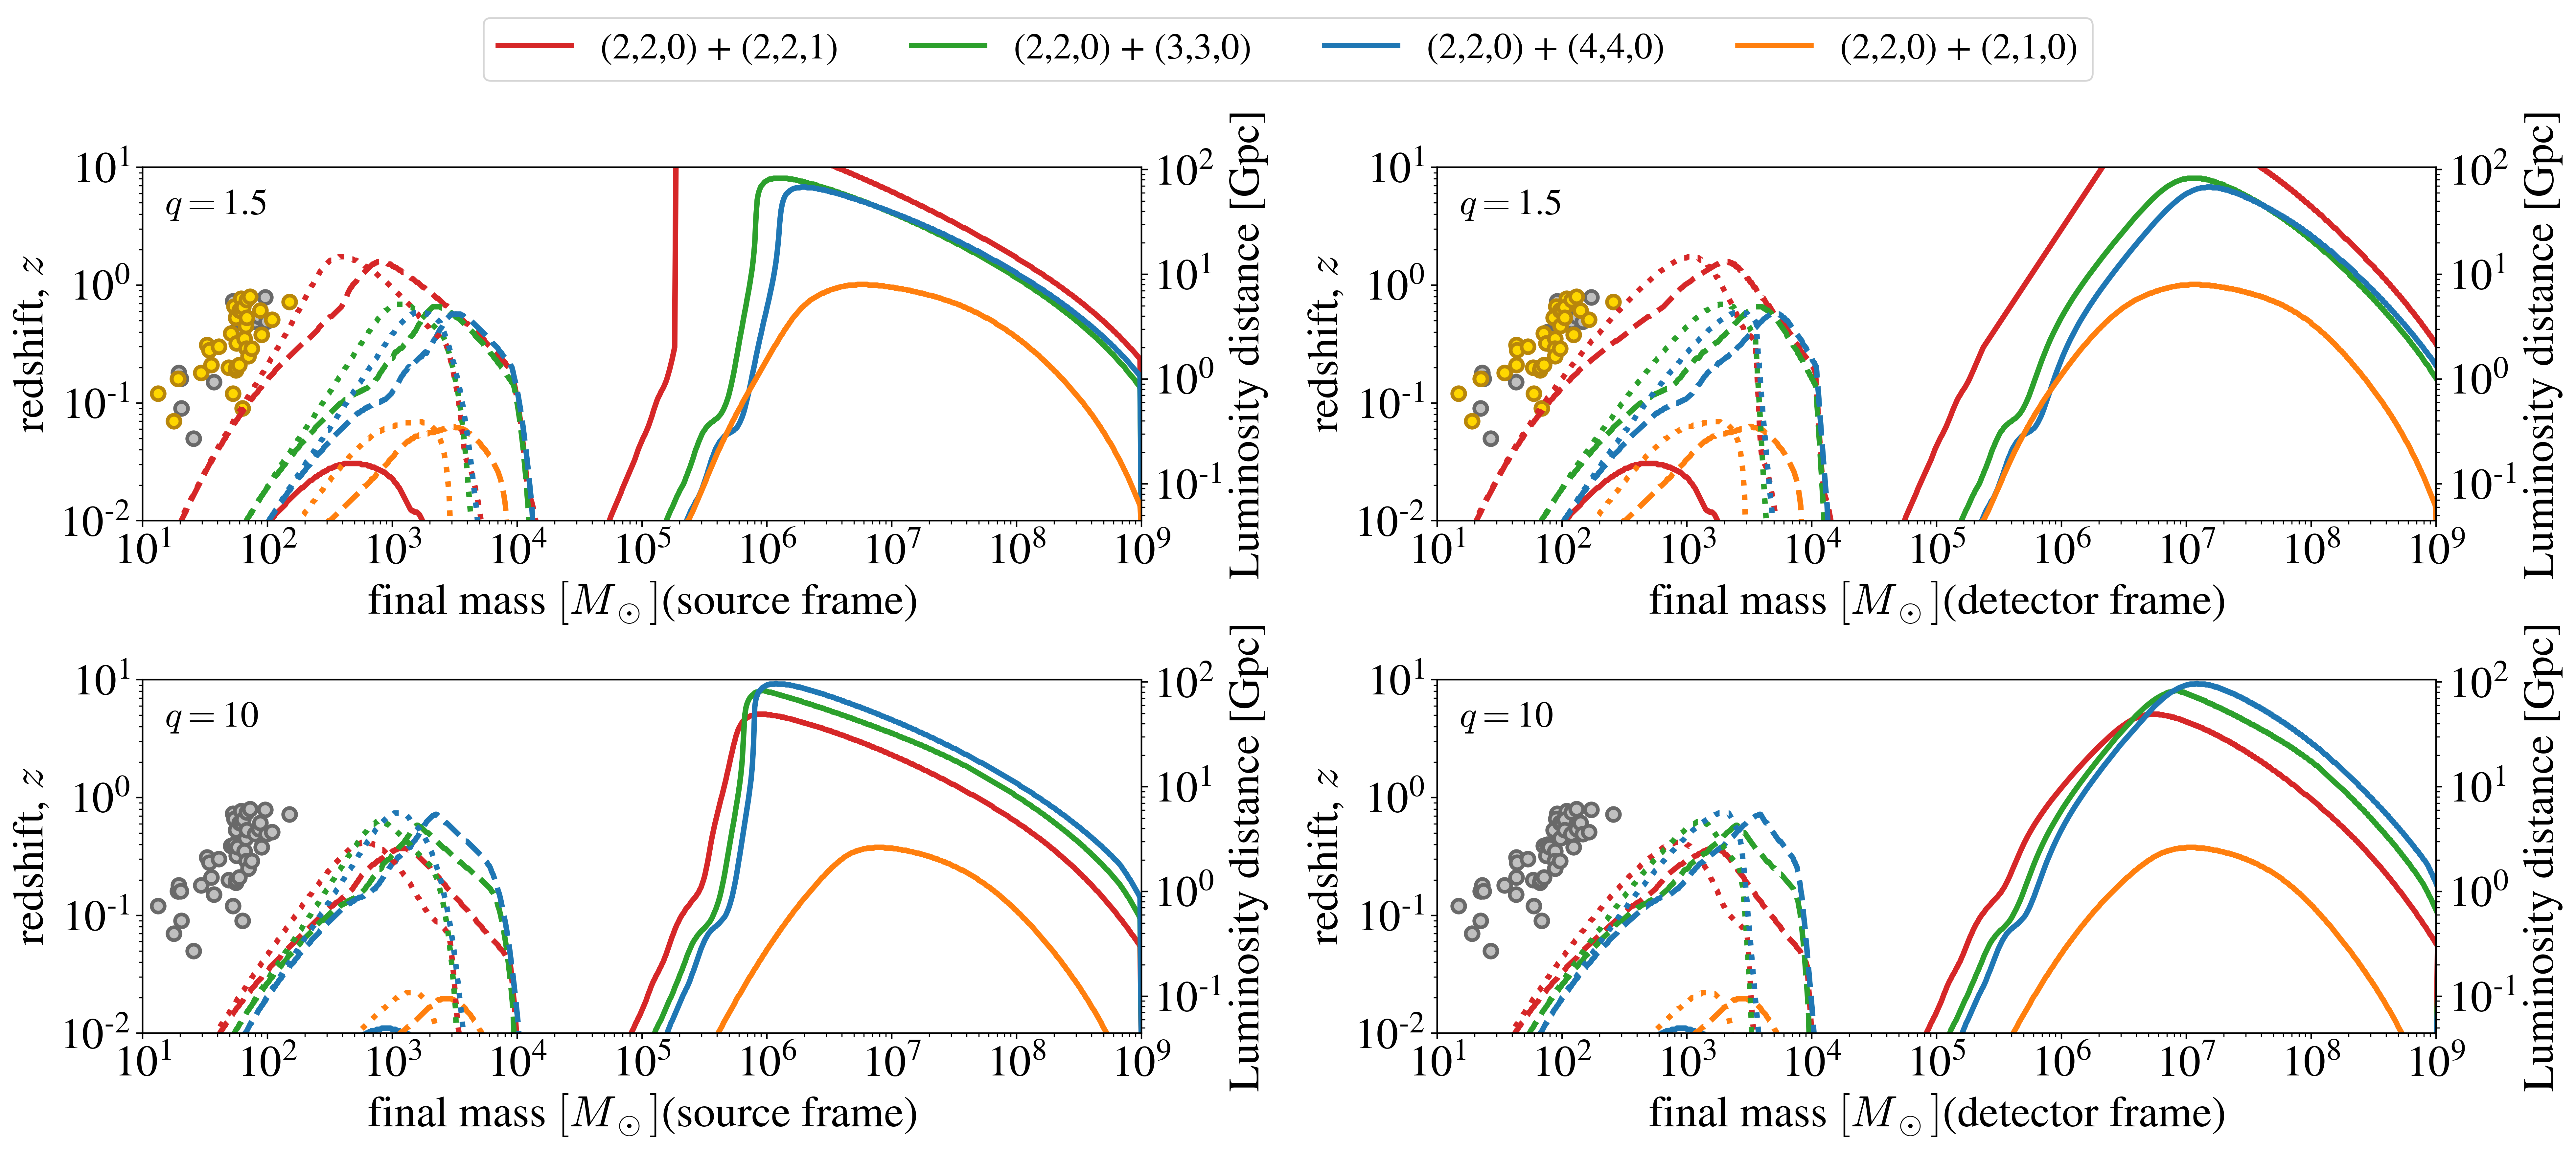

In [8]:

plot_2_modes(data_frame)